### First Cut Model

In [1]:
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')

### Now I can use this data to train model

In [2]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

In [5]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.3,random_state=42,stratify=y_train)

In [6]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3787, 246), (1623, 246), (3787,), (1623,))

In [7]:
from collections import Counter
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


## Oversample the data using SMOTE to make it 20:80 ratio

In [8]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns

#### Use GridSearchCV to find best parameters for Logistic Regression

In [10]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os, y_tr_os)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapil\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [11]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9441371559211322


#### Now train with best parameters using LogisticRegression

In [12]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

In [17]:
from matplotlib import pyplot as plt


def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(visible=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [18]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [19]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

Train AUC =  0.9465227461149396
Test AUC =  0.9504052023328204


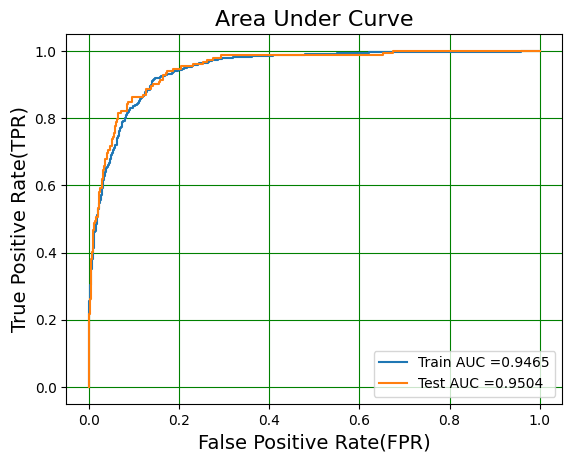

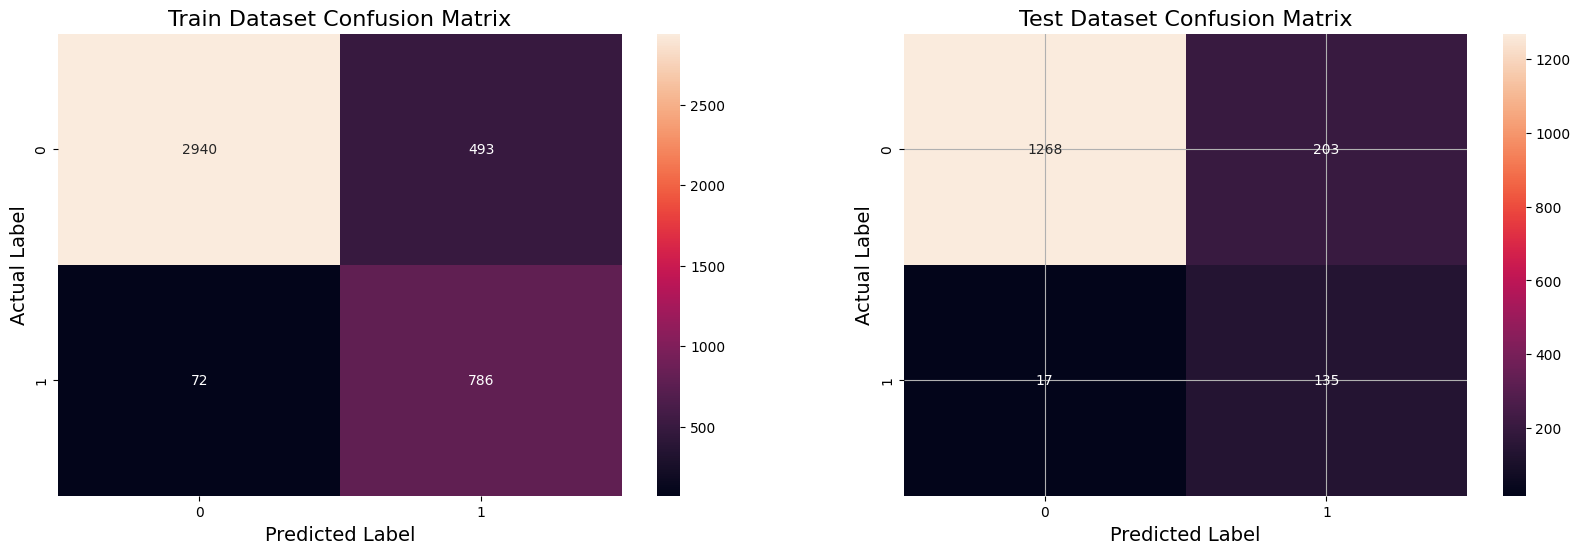

Best Threshold = 0.1201
Model AUC is : 0.9504
Model F1 Score is : 0.5510


In [20]:
import matplotlib.pyplot as plt

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Use GridSearchCV for DecisionTreeClassifier

In [21]:
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [22]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 200}
roc_auc_score : 0.9392546411205048


#### Train DecisionTreeClassifier with best hyperparameters

In [23]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9560662417493178
Test AUC =  0.9068996207377724


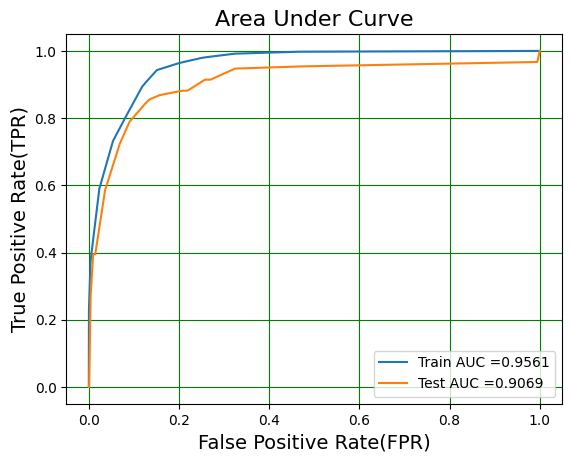

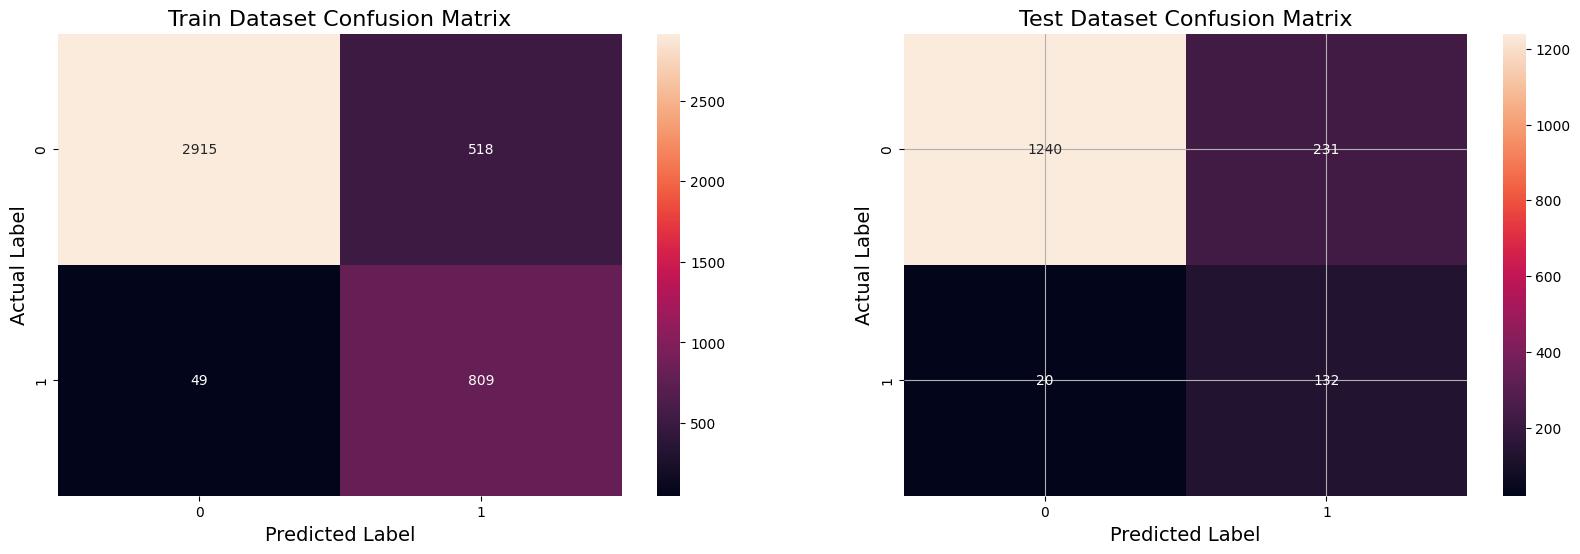

Best Threshold = 0.2703
Model AUC is : 0.9069
Model F1 Score is : 0.5126


In [24]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Use RandomSearchCV for SupportVectorClassifier

In [25]:
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [26]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l1'}
roc_auc_score : 0.9437082985272621


In [27]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9535768629855434
Test AUC =  0.9387902966116856


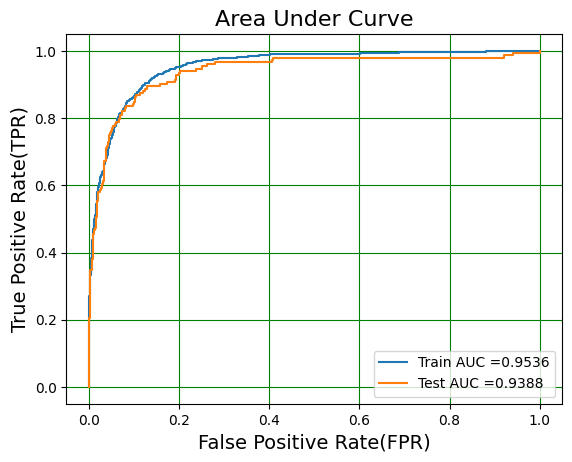

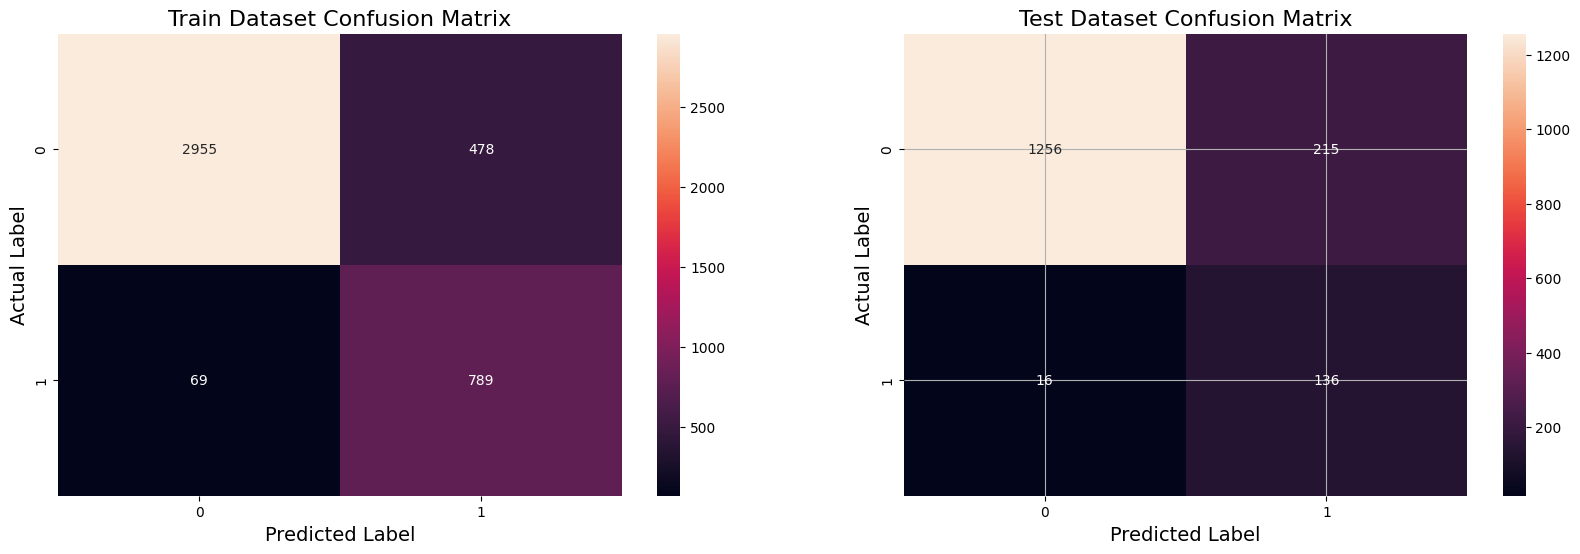

Best Threshold = 0.1212
Model AUC is : 0.9388
Model F1 Score is : 0.5408


In [28]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Train GaussianNB Classifier

In [29]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8572551344179659
Test AUC =  0.8807627285412716


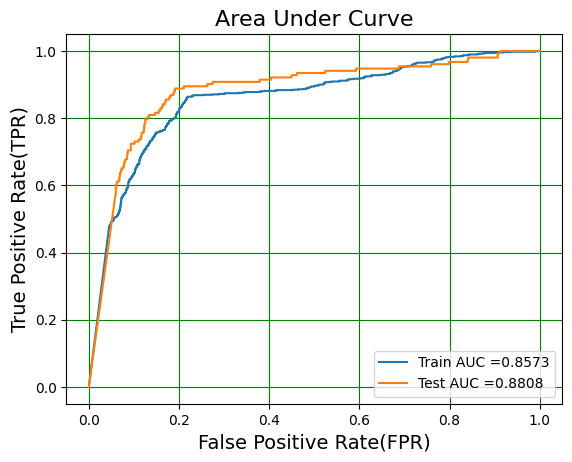

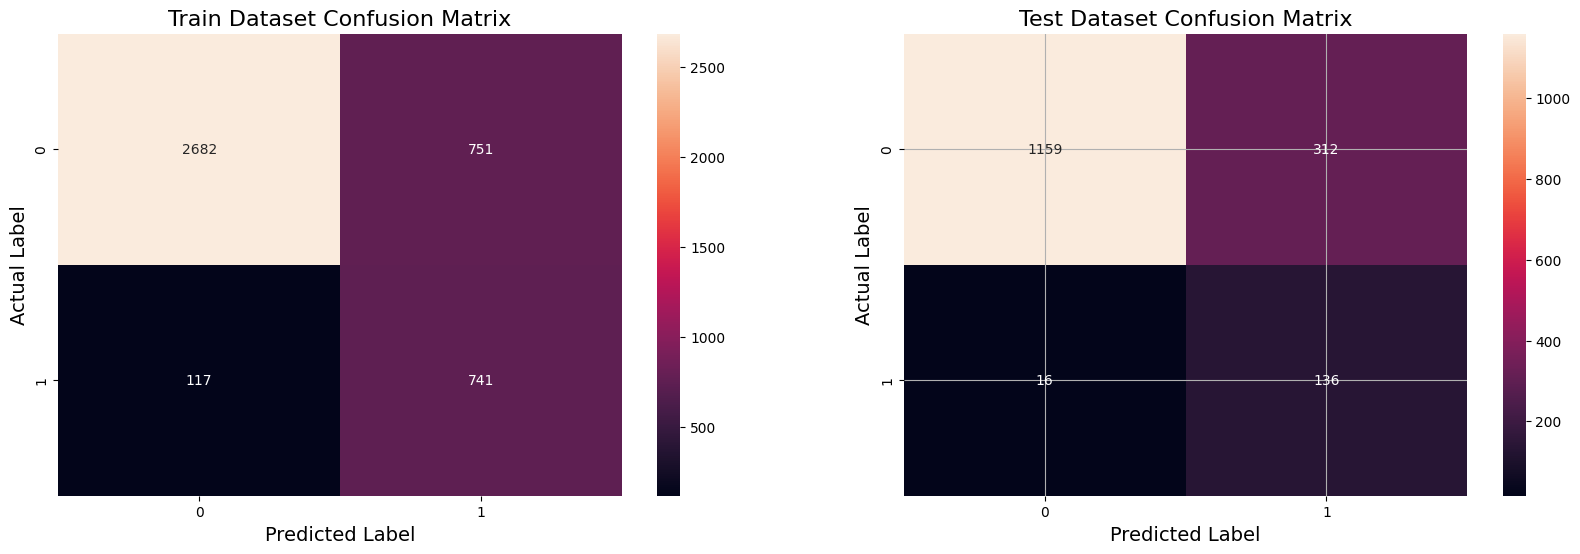

Best Threshold = 0.0000
Model AUC is : 0.8808
Model F1 Score is : 0.4533


In [30]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Observation on models for oversampling (20:80) data

In [32]:
%pip install beautifultable


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.55"])
table.append_row(["Decision Tree", "0.90", "0.53"])
table.append_row(["Support Vector Classifier", "0.94", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.46"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.55   |
+---------------------------+------+----------+
|       Decision Tree       | 0.9  |   0.53   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.46   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

## Oversample the data using SMOTE to make it 25:75 ratio

In [35]:
oversample = SMOTE(sampling_strategy=0.33)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 24.80% and Non-Fraud Percentage = 75.20%


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


### Train with LogisticRegression model

In [36]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9427838203098382
Test AUC =  0.9500339904826649


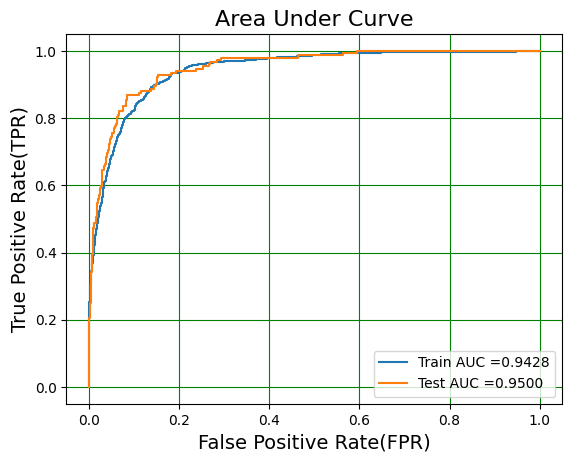

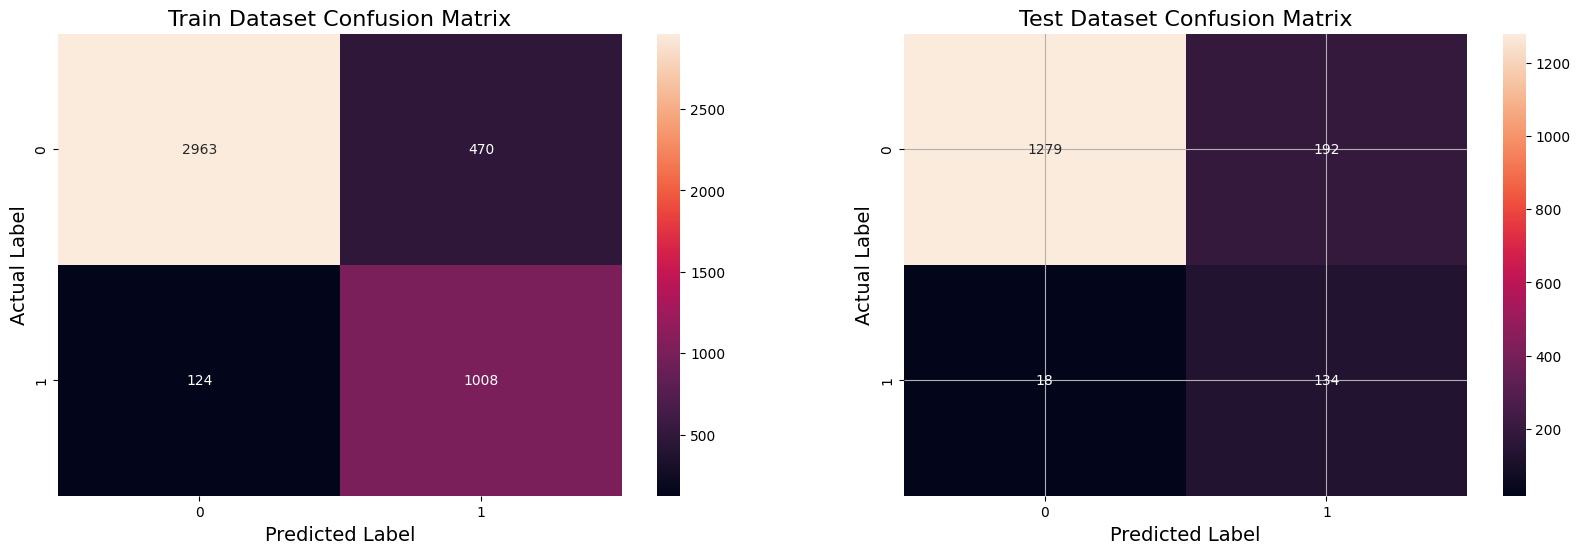

Best Threshold = 0.1621
Model AUC is : 0.9500
Model F1 Score is : 0.5607


In [37]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [38]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9597624233304067
Test AUC =  0.9150237933378654


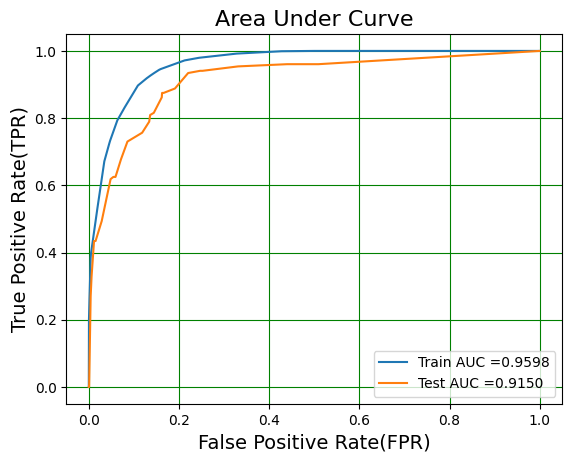

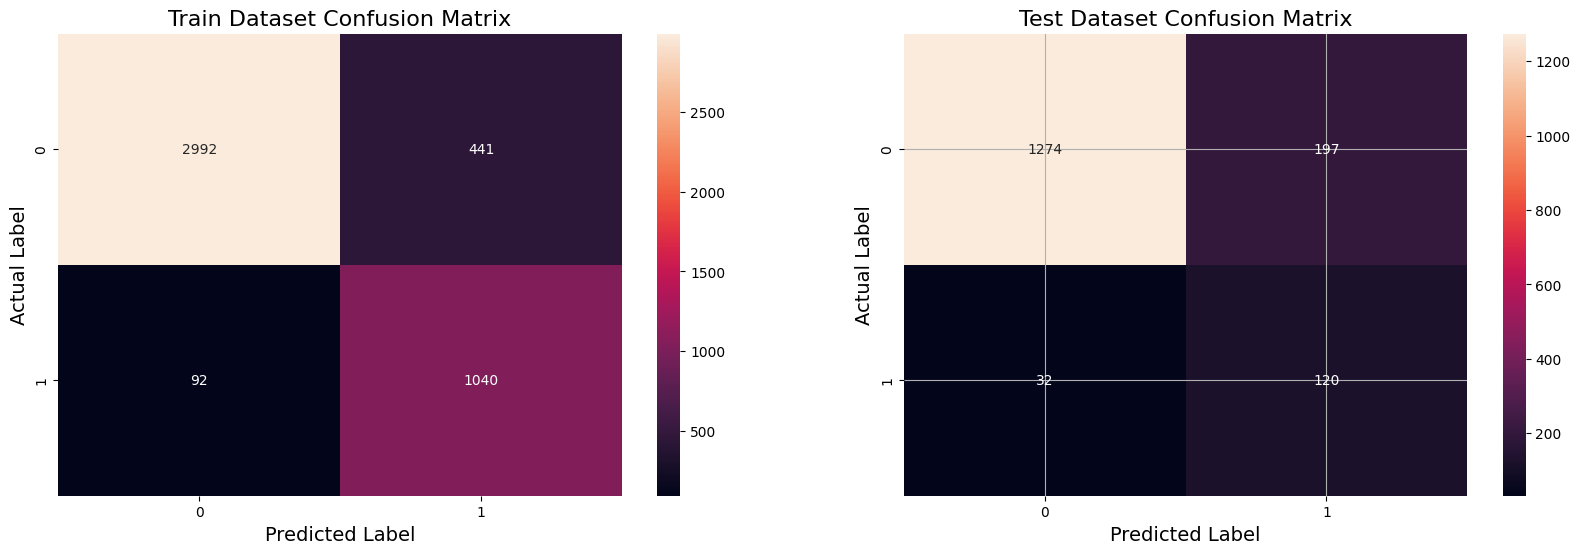

Best Threshold = 0.2667
Model AUC is : 0.9150
Model F1 Score is : 0.5117


In [39]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [40]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9518938508901856
Test AUC =  0.934604100325593


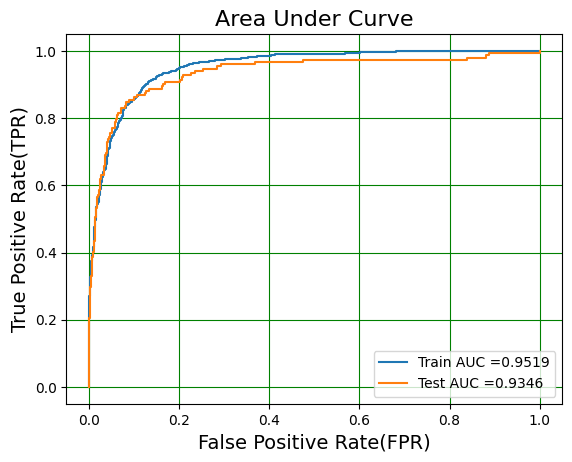

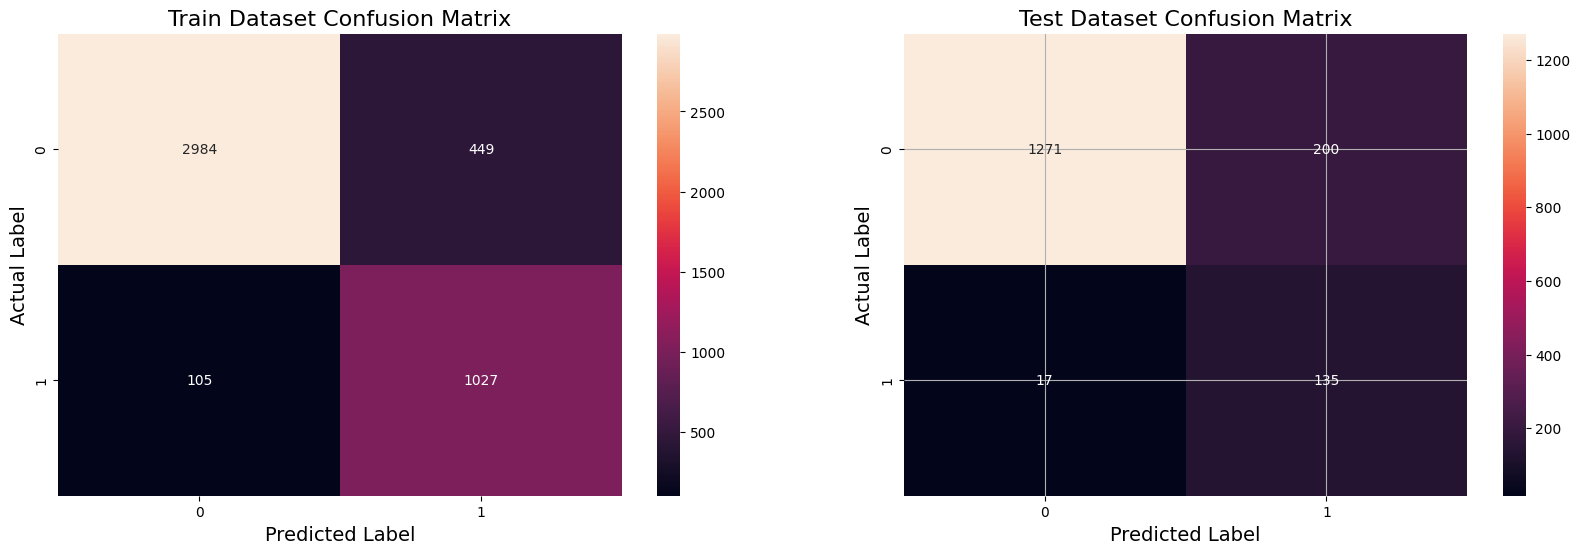

Best Threshold = 0.1661
Model AUC is : 0.9346
Model F1 Score is : 0.5544


In [41]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [42]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8456599529200577
Test AUC =  0.883891194676017


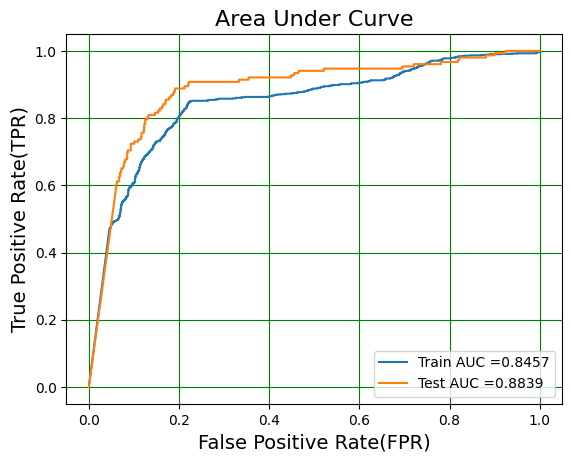

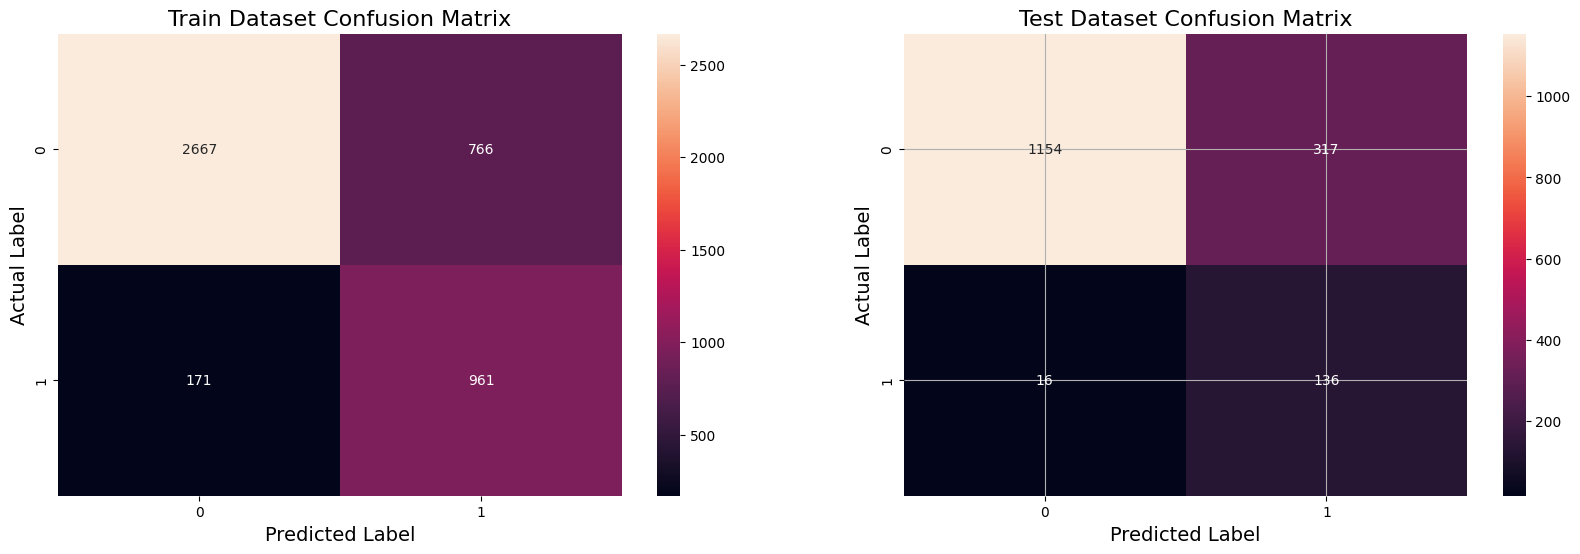

Best Threshold = 0.0000
Model AUC is : 0.8839
Model F1 Score is : 0.4496


In [43]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [44]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.54"])
table.append_row(["Decision Tree", "0.92", "0.47"])
table.append_row(["Support Vector Classifier", "0.94", "0.53"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.54   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.47   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.53   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best for 25:75 ratio sampled data.

## Oversample the data using SMOTE to make it 35:65 ratio

In [45]:
oversample = SMOTE(sampling_strategy=0.54)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 35.05% and Non-Fraud Percentage = 64.95%


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


### Train with LogisticRegression model

In [46]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9488232763207929
Test AUC =  0.9481913485276753


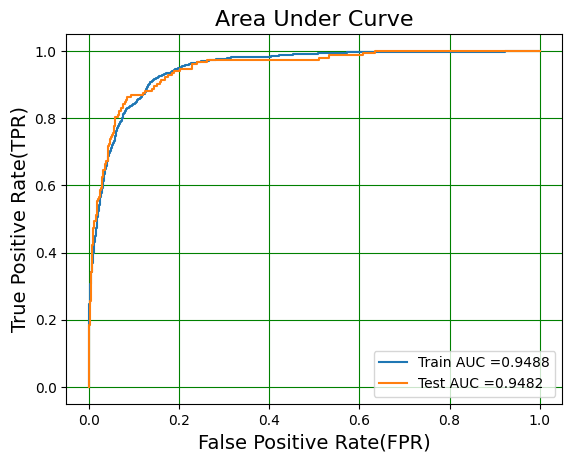

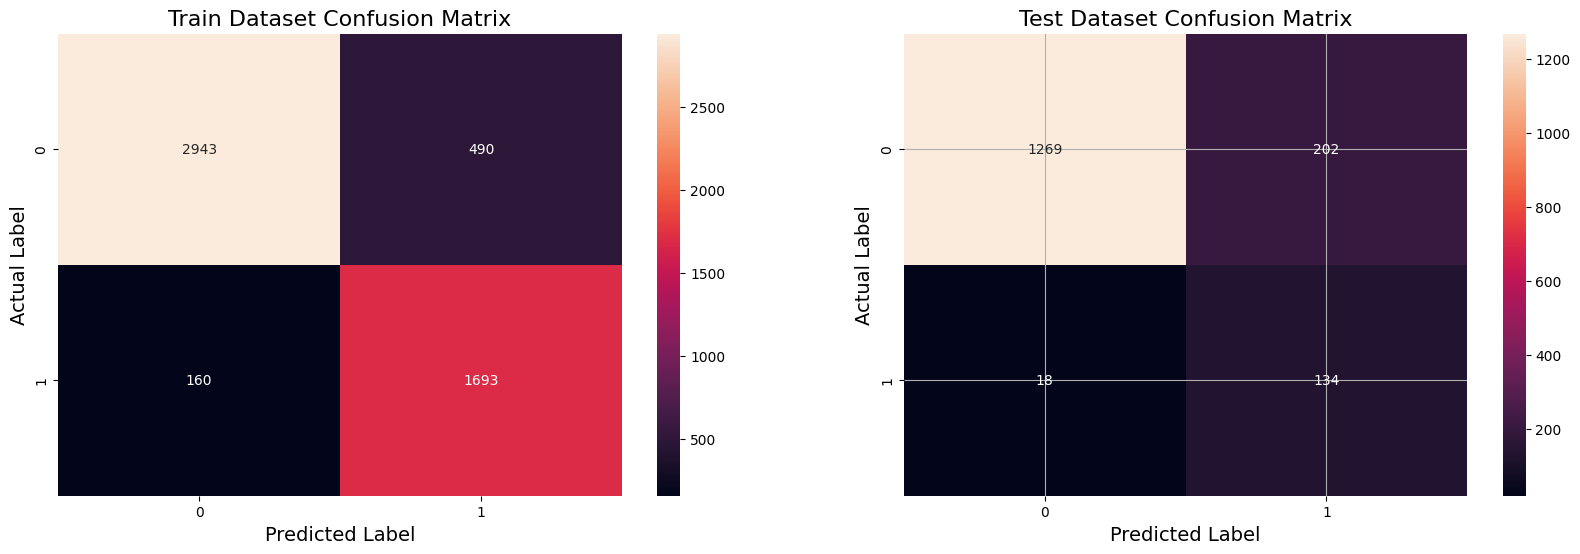

Best Threshold = 0.2110
Model AUC is : 0.9482
Model F1 Score is : 0.5492


In [47]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [48]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9634339351606083
Test AUC =  0.9035363519267237


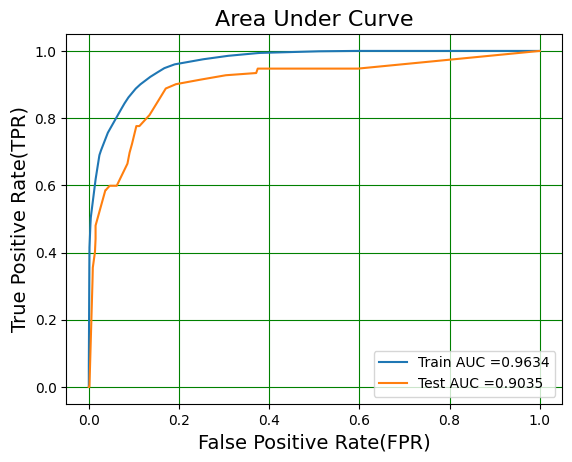

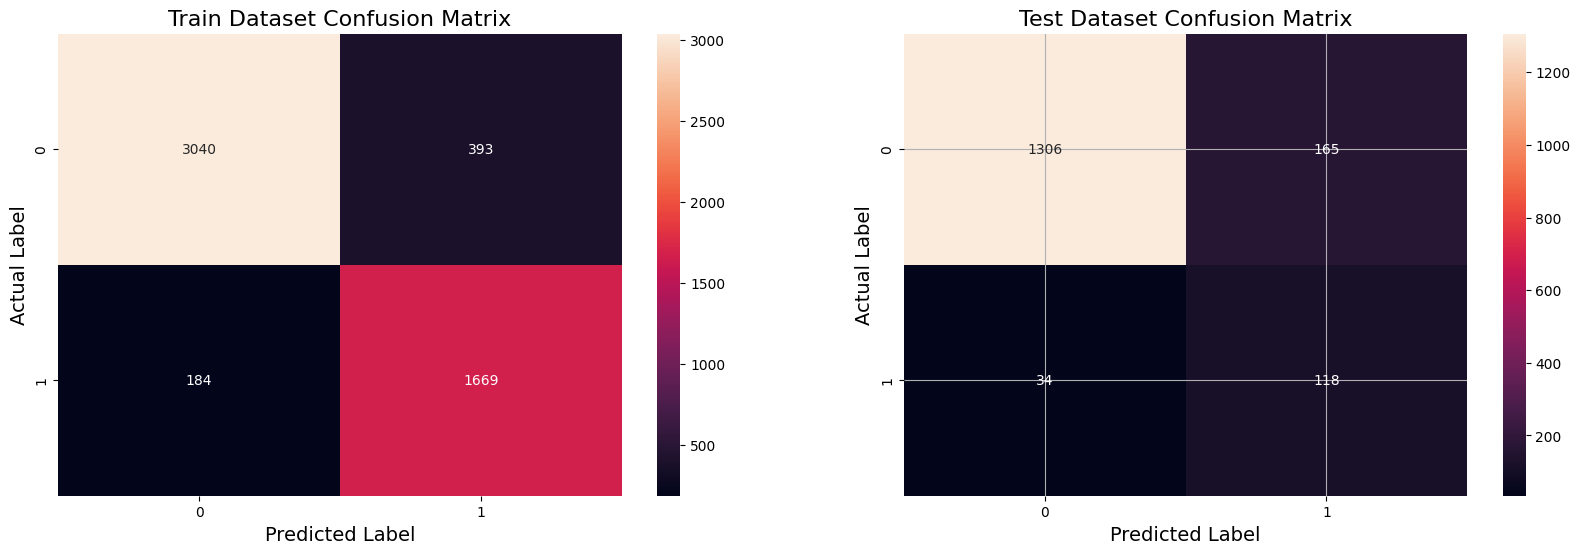

Best Threshold = 0.4000
Model AUC is : 0.9035
Model F1 Score is : 0.5425


In [49]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [50]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9579630043879057
Test AUC =  0.938106014526459


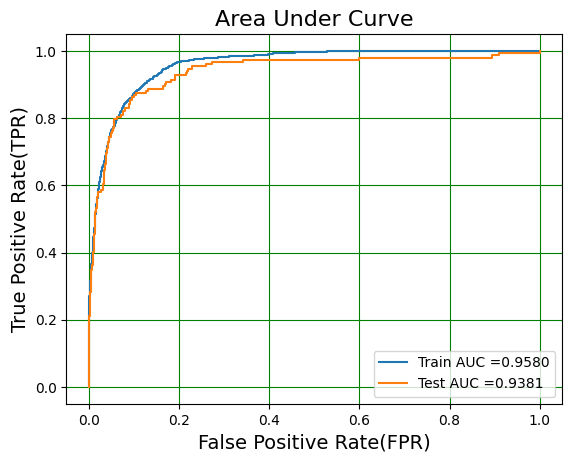

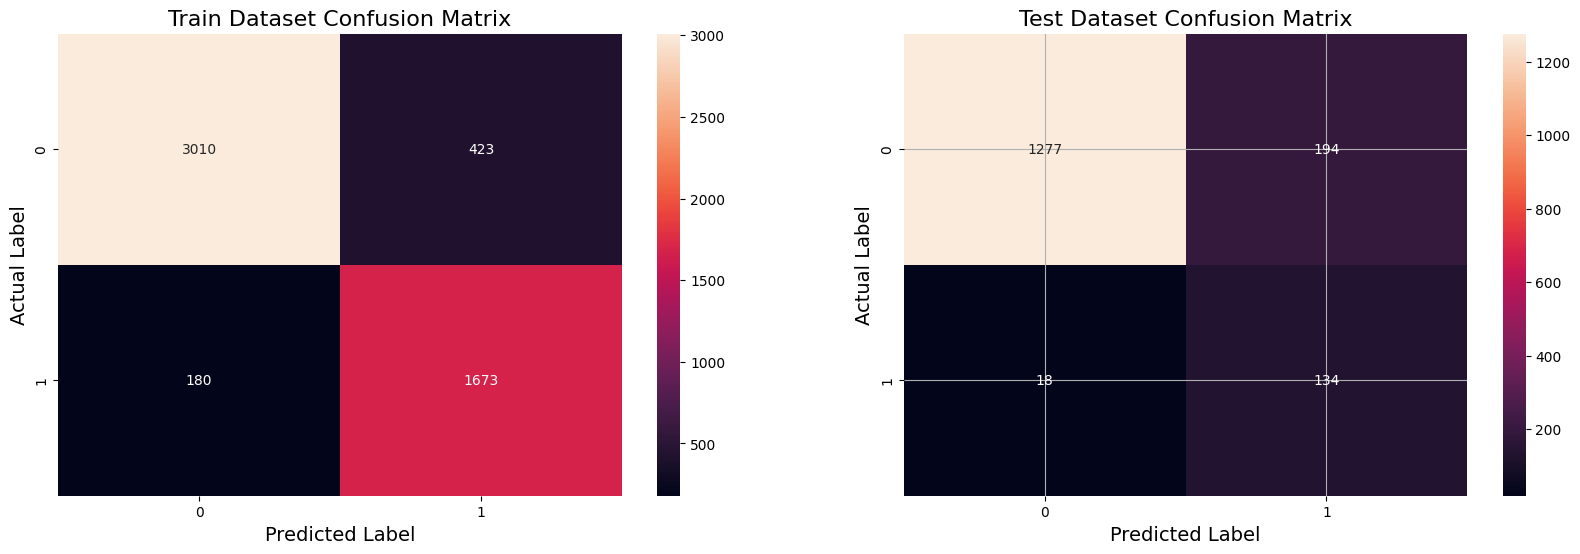

Best Threshold = 0.2344
Model AUC is : 0.9381
Model F1 Score is : 0.5583


In [51]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [52]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8582915353331503
Test AUC =  0.8832784715016637


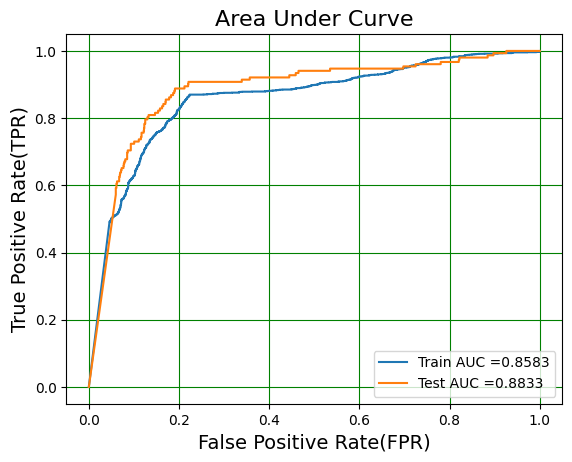

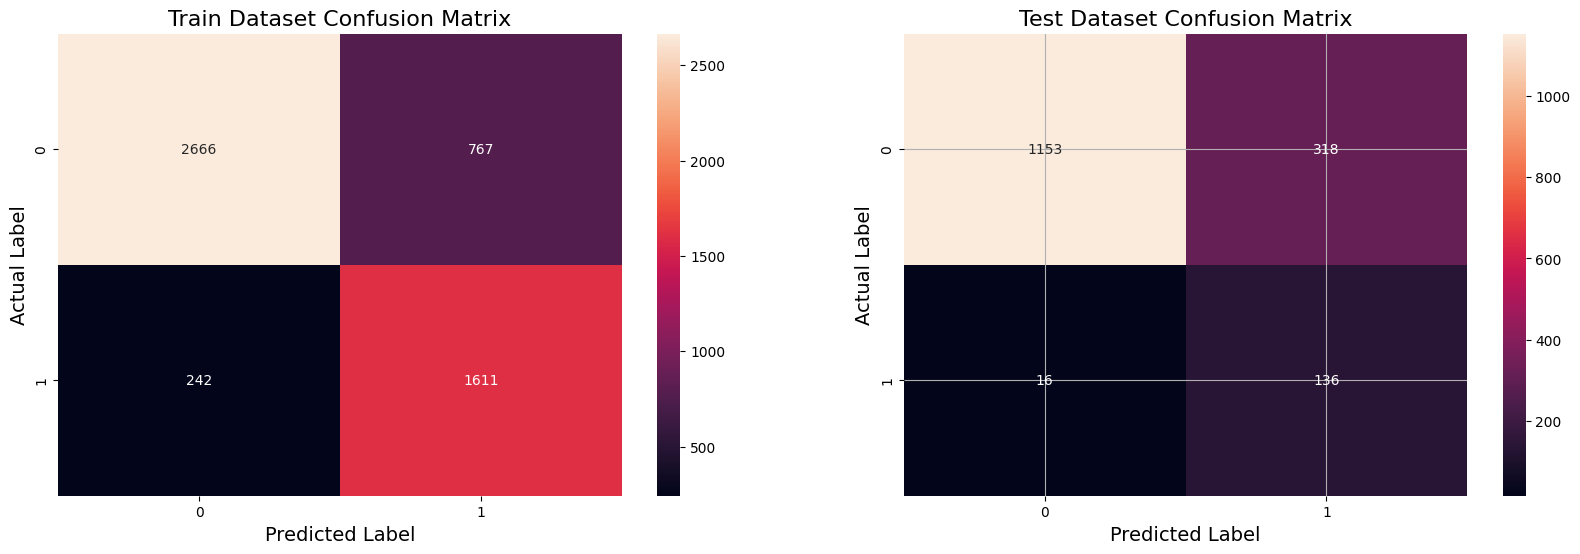

Best Threshold = 0.0000
Model AUC is : 0.8833
Model F1 Score is : 0.4488


In [53]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [54]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.53"])
table.append_row(["Decision Tree", "0.92", "0.55"])
table.append_row(["Support Vector Classifier", "0.94", "0.58"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.53   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.55   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.58   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best. For SVC and Decision tree F! score is higher than LR. Still I will consider LR as the best model because AUC is high for LR.

## Oversample the data using SMOTE to make it 50:50 ratio

In [55]:
oversample = SMOTE(sampling_strategy=1)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 50.00% and Non-Fraud Percentage = 50.00%


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


### Train with LogisticRegression model

In [56]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9490654991065707
Test AUC =  0.9439738452180757


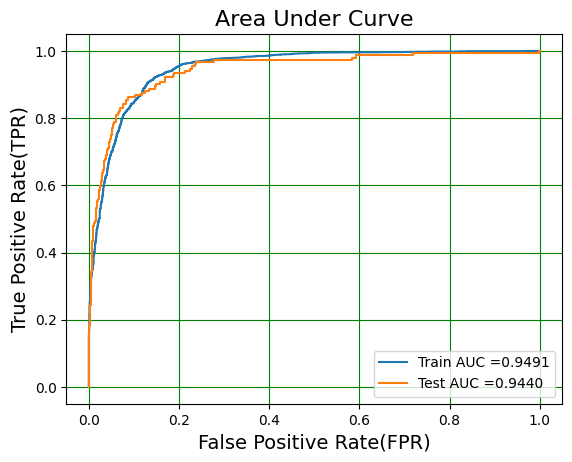

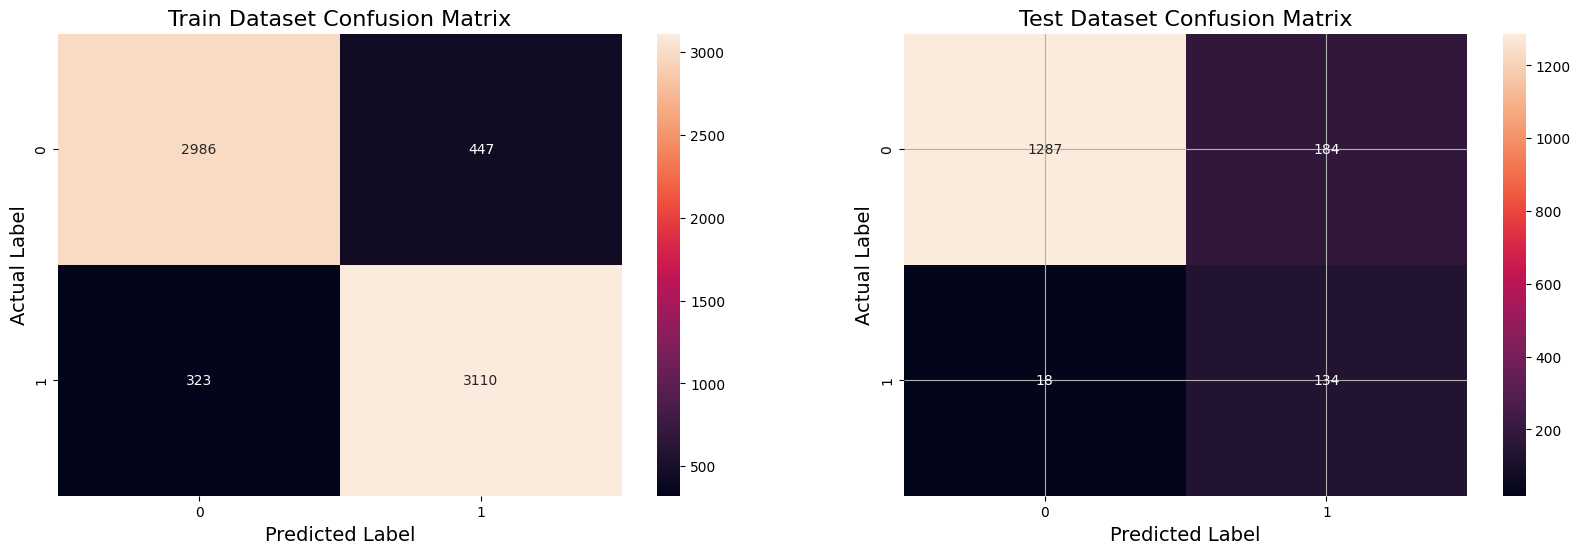

Best Threshold = 0.3502
Model AUC is : 0.9440
Model F1 Score is : 0.5702


In [57]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [58]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9675479311889392
Test AUC =  0.8904701420444381


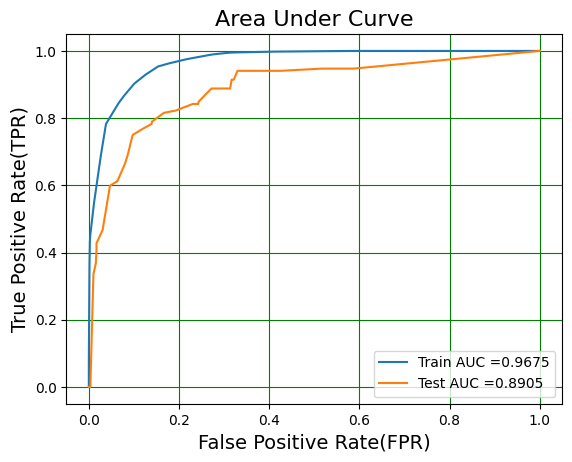

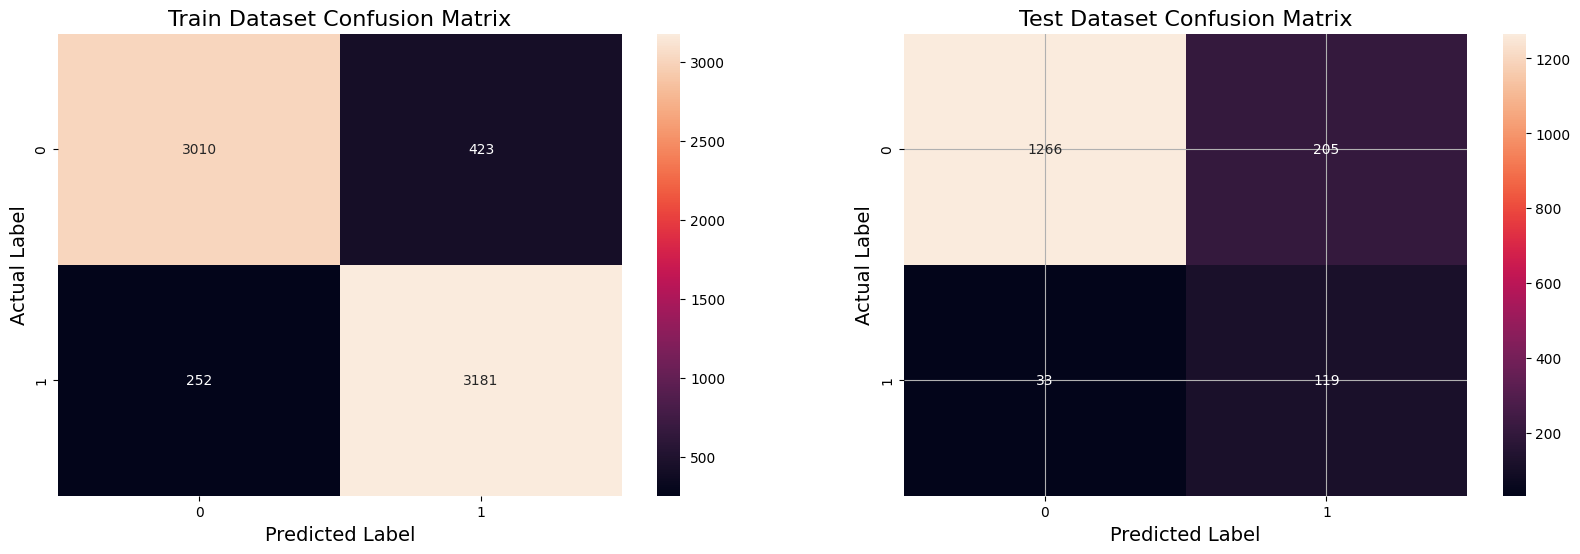

Best Threshold = 0.5157
Model AUC is : 0.8905
Model F1 Score is : 0.5000


In [59]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [60]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9574849206511499
Test AUC =  0.9389647214569394


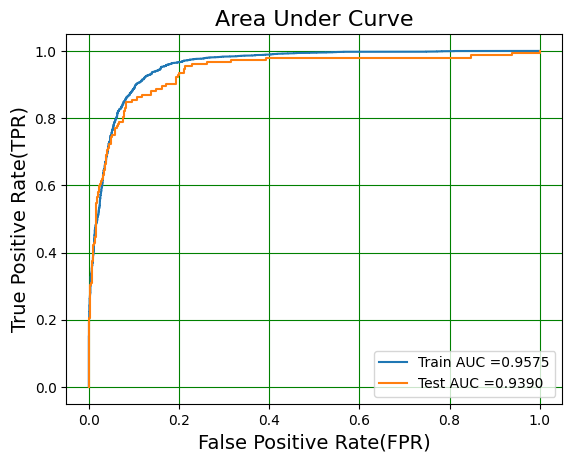

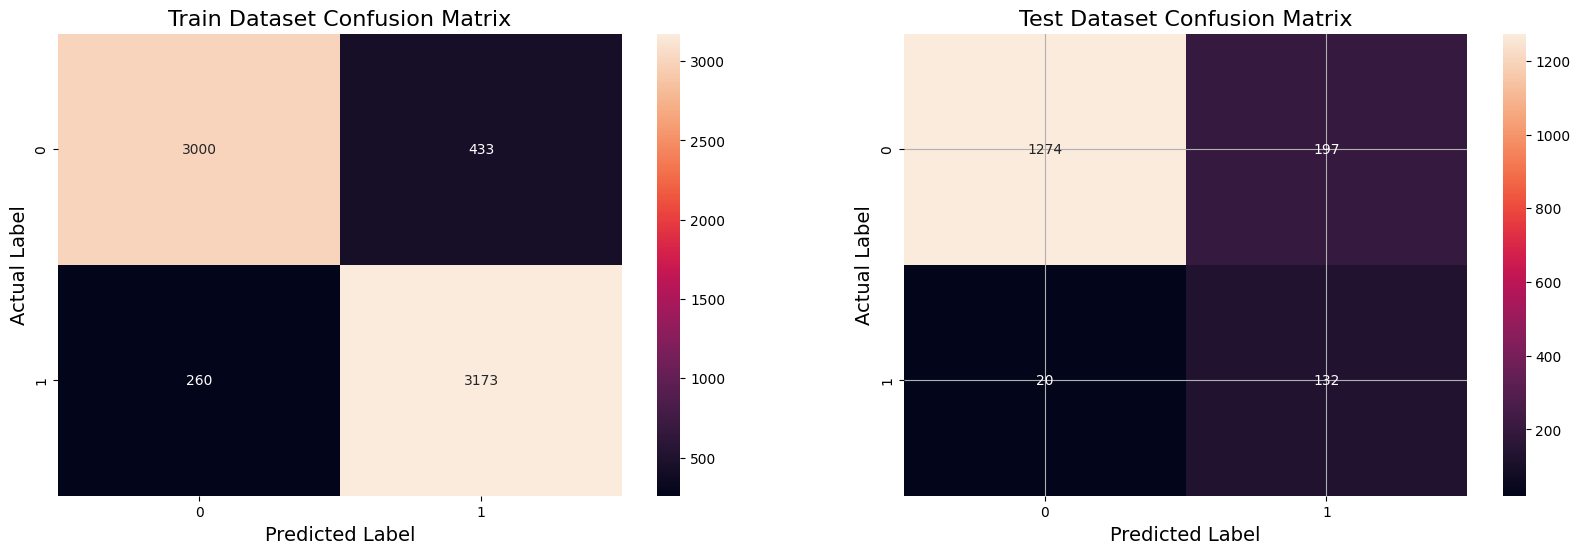

Best Threshold = 0.3362
Model AUC is : 0.9390
Model F1 Score is : 0.5489


In [61]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [62]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8473556761200151
Test AUC =  0.880217091845862


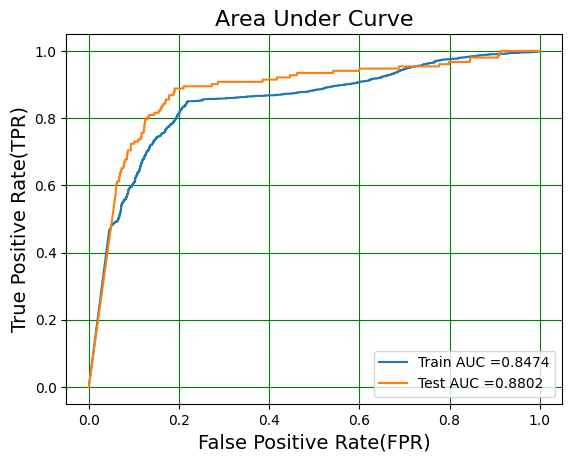

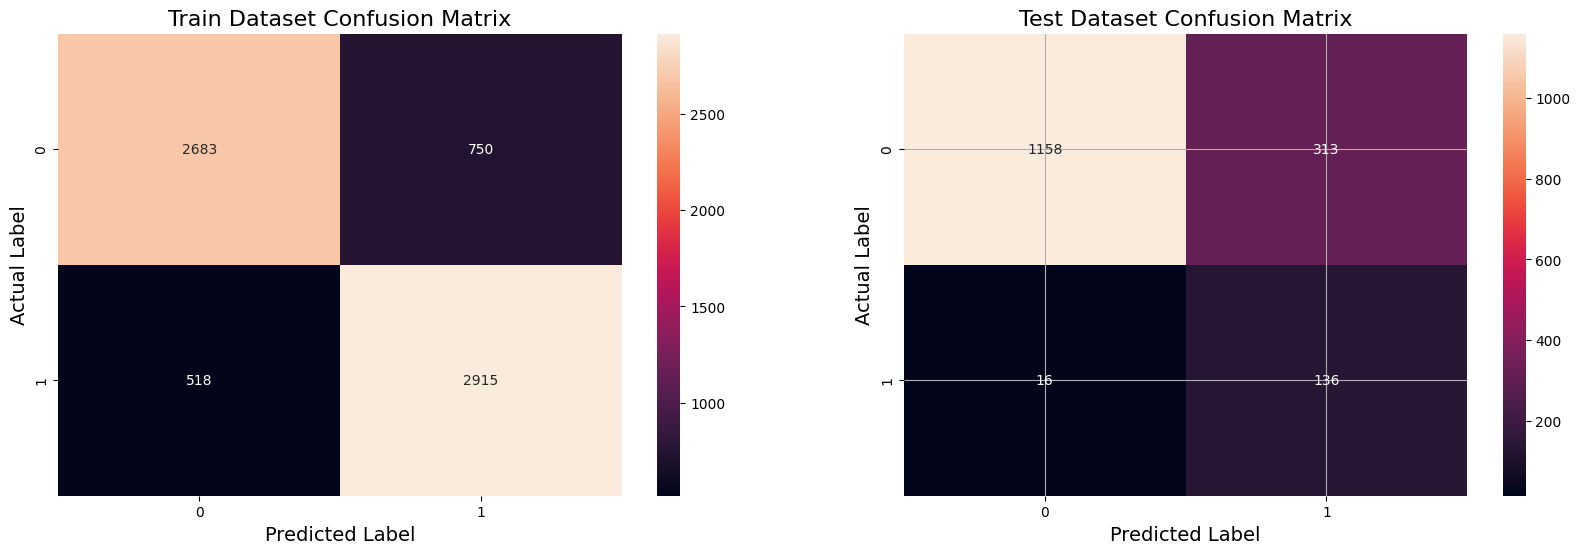

Best Threshold = 0.0000
Model AUC is : 0.8802
Model F1 Score is : 0.4526


In [63]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [64]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.94", "0.56"])
table.append_row(["Decision Tree", "0.91", "0.51"])
table.append_row(["Support Vector Classifier", "0.93", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.94 |   0.56   |
+---------------------------+------+----------+
|       Decision Tree       | 0.91 |   0.51   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.93 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Conclusion:
This time also after comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

### Overall observation accross all the sampling ratio.

In [65]:
table = BeautifulTable() 
table.column_headers= ["Sampling Ratio", "Best Model", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Regression", "0.95", "0.55"])
table.append_row(["75:25", "Logistic Regression", "0.95", "0.54"])
table.append_row(["65:35", "Logistic Regression", "0.95", "0.53"])
table.append_row(["50:50", "Logistic Regression", "0.94", "0.56"])
print(table)

+----------------+---------------------+----------+----------+
| Sampling Ratio |     Best Model      |   AUC    | F1 Score |
+----------------+---------------------+----------+----------+
|     80:20      | Logistic Regression |   0.95   |   0.55   |
+----------------+---------------------+----------+----------+
|     75:25      | Logistic Regression |   0.95   |   0.54   |
+----------------+---------------------+----------+----------+
|     65:35      | Logistic Regression |   0.95   |   0.53   |
+----------------+---------------------+----------+----------+
|     50:50      | Logistic Regression |   0.94   |   0.56   |
+----------------+---------------------+----------+----------+


### Conclusion:
Logistic Regression is performing good accross all the sampling ratio. But if we look at both AUC and F1 score, the model with Sampling Ratio 80:20 is the best model for this problem.

<h2> Important Feature Selection Using Random Forest </h2>

In [66]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [67]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os, y_tr_os)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py"

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [68]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}
roc_auc_score : 0.9713056940559562


In [70]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=20, random_state=42)
random_forest.fit(x_tr_os, y_tr_os)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9998248183508888
Test AUC =  0.9439604279222871


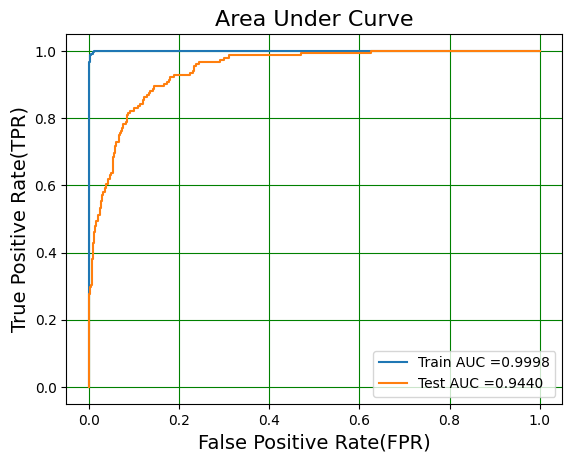

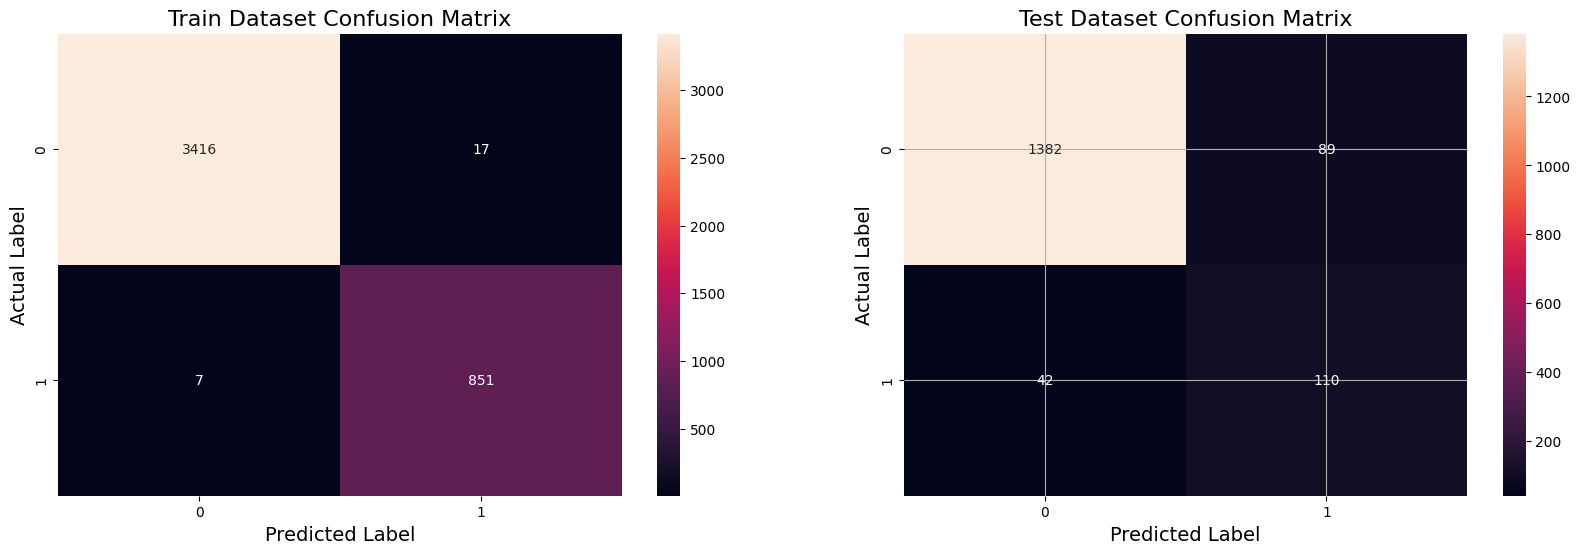

Best Threshold = 0.4234
Model AUC is : 0.9440
Model F1 Score is : 0.6268


In [71]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

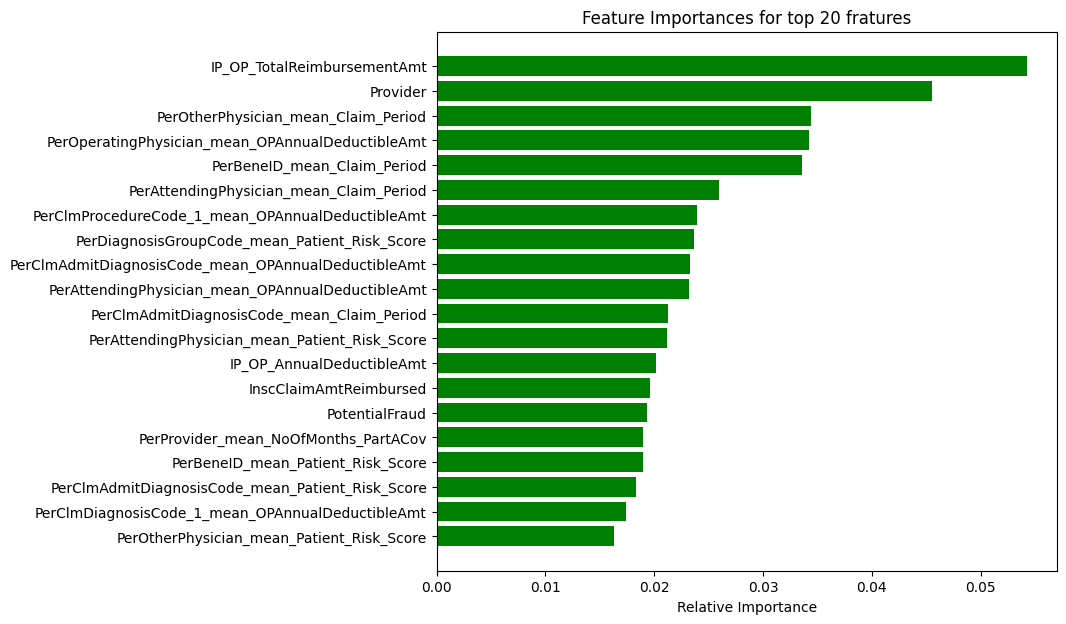

In [72]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot top 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()

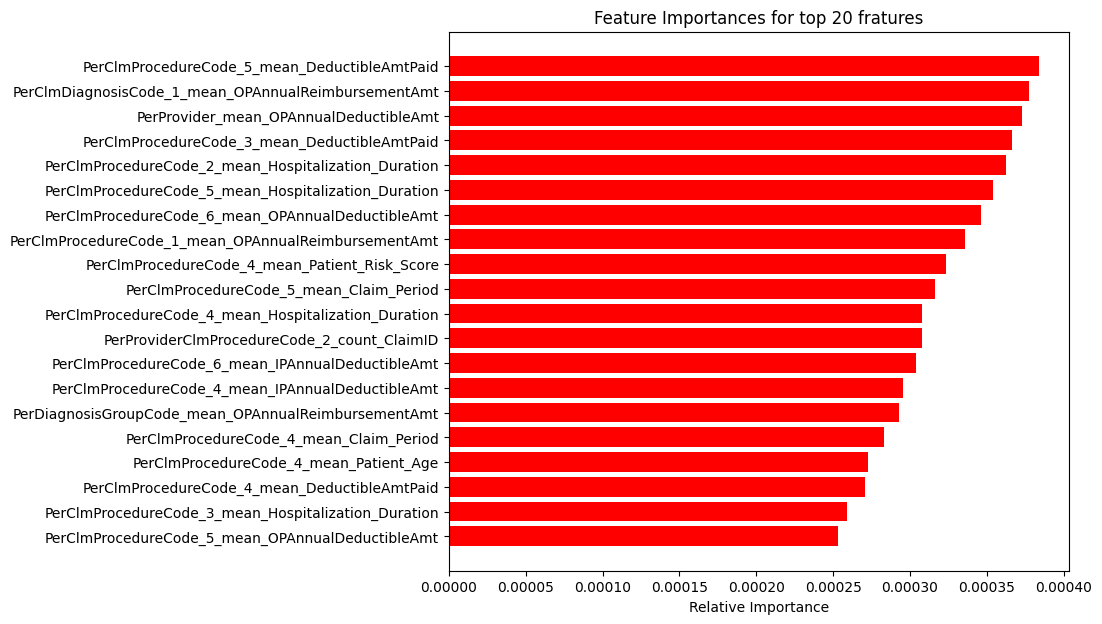

In [73]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot least important 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
least_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(least_20_indices)), importance_of_feature[least_20_indices], color='r', align='center')
plt.yticks(range(len(least_20_indices)), [features[i] for i in least_20_indices])
plt.xlabel('Relative Importance')
plt.show()

#### plot the distribution of features with FE>0

C:\Users\kapil\AppData\Local\Temp\ipykernel_20648\4245609559.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(importance_of_feature[importance_of_feature>0])


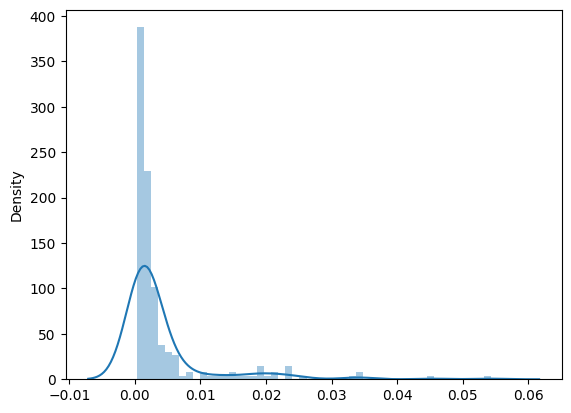

In [74]:
importance_of_feature = random_forest.feature_importances_
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0])
plt.show()

In [75]:
len(importance_of_feature[importance_of_feature>0])

246

#### plot the distribution of features with FE>0.001

C:\Users\kapil\AppData\Local\Temp\ipykernel_20648\4158615194.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(importance_of_feature[importance_of_feature>0.001])


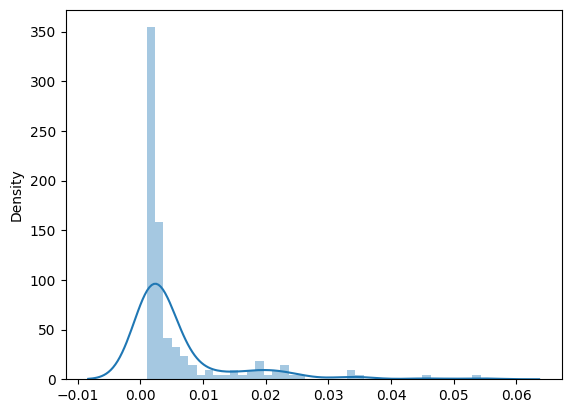

In [76]:
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0.001])
plt.show()

In [77]:
len(importance_of_feature[importance_of_feature>0.001])

161

### Take top 161 features based on feature importance

In [78]:
# take all the feature columns in a list
features = list(x_train.columns)
imp_feature_indx = np.argsort(random_forest.feature_importances_)[::-1]
imp_value = np.take(random_forest.feature_importances_, imp_feature_indx[:161])
imp_feature_name = list(np.take(features, imp_feature_indx[:161]))

In [79]:
x_train_imp_features = x_train[imp_feature_name]
x_train_imp_features.shape

(5410, 161)

In [80]:
x_test_imp_features = x_test[imp_feature_name]
x_test_imp_features.shape

(1353, 161)

In [81]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train_imp_features)
x_train_if_std = standard_scaler.transform(x_train_imp_features)
x_test_if_std = standard_scaler.transform(x_test_imp_features)

In [82]:
# split the data into train and test
x_tr_if, x_val_if, y_tr_if, y_val_if = train_test_split(x_train_if_std, y_train, test_size=0.3,random_state=42,stratify=y_train)
x_tr_if.shape, x_val_if.shape, y_tr_if.shape, y_val_if.shape

((3787, 161), (1623, 161), (3787,), (1623,))

In [83]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os_if, y_tr_os_if = oversample.fit_resample(x_tr_if, y_tr_if)
counter = Counter(y_tr_os_if)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [84]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os_if, y_tr_os_if)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapil\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [85]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9406247340139297


In [86]:
log_reg = LogisticRegression(C=1.0, penalty='l2')
log_reg.fit(x_tr_os_if, y_tr_os_if)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Train AUC =  0.9463862673883063
Test AUC =  0.9407358045010555


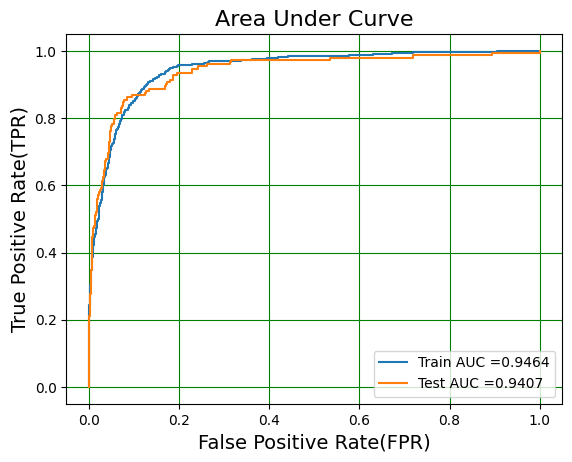

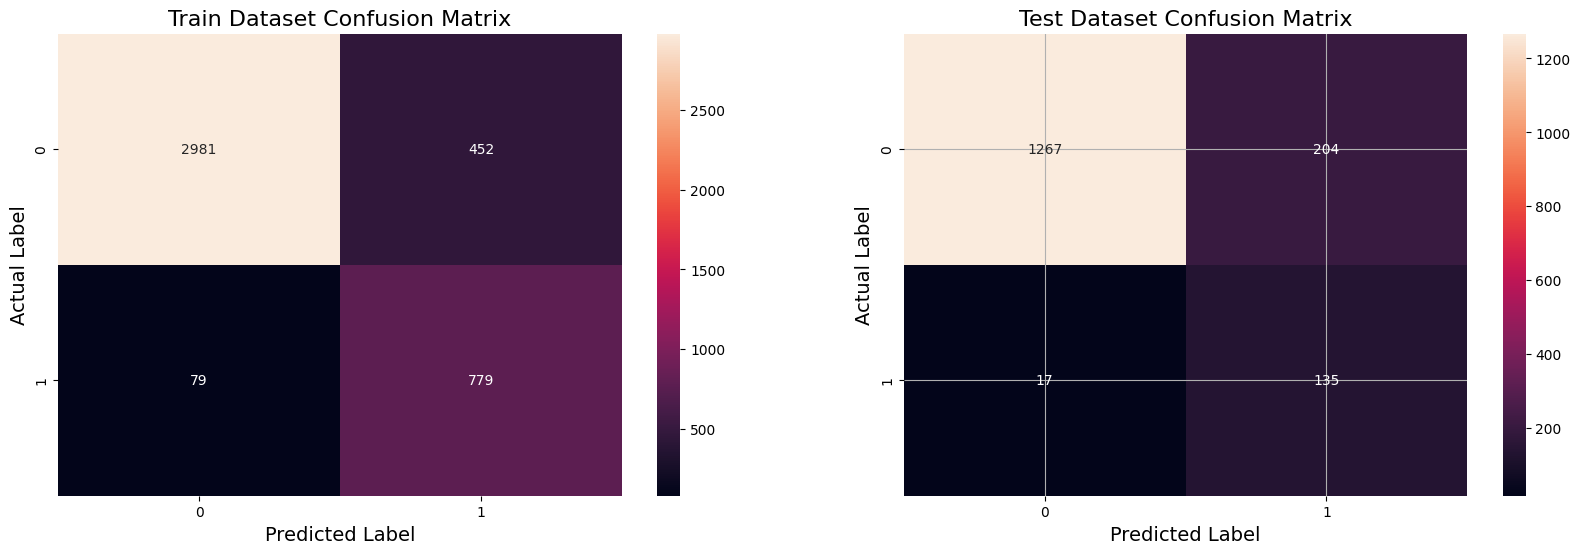

Best Threshold = 0.1282
Model AUC is : 0.9407
Model F1 Score is : 0.5499


In [87]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Now train Random Forest with important features

In [88]:
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os_if, y_tr_os_if)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [89]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}
roc_auc_score : 0.9724390877531812


In [90]:
random_forest = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_features='sqrt', max_depth=20, random_state=42)
random_forest.fit(x_tr_os_if, y_tr_os_if)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       random_state=42)

Train AUC =  0.99980139289781
Test AUC =  0.9426186983434112


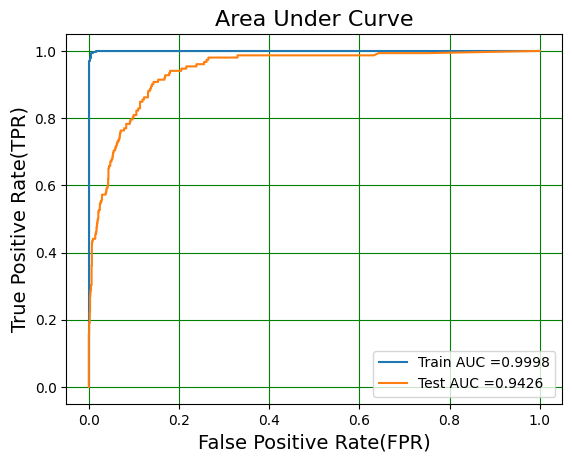

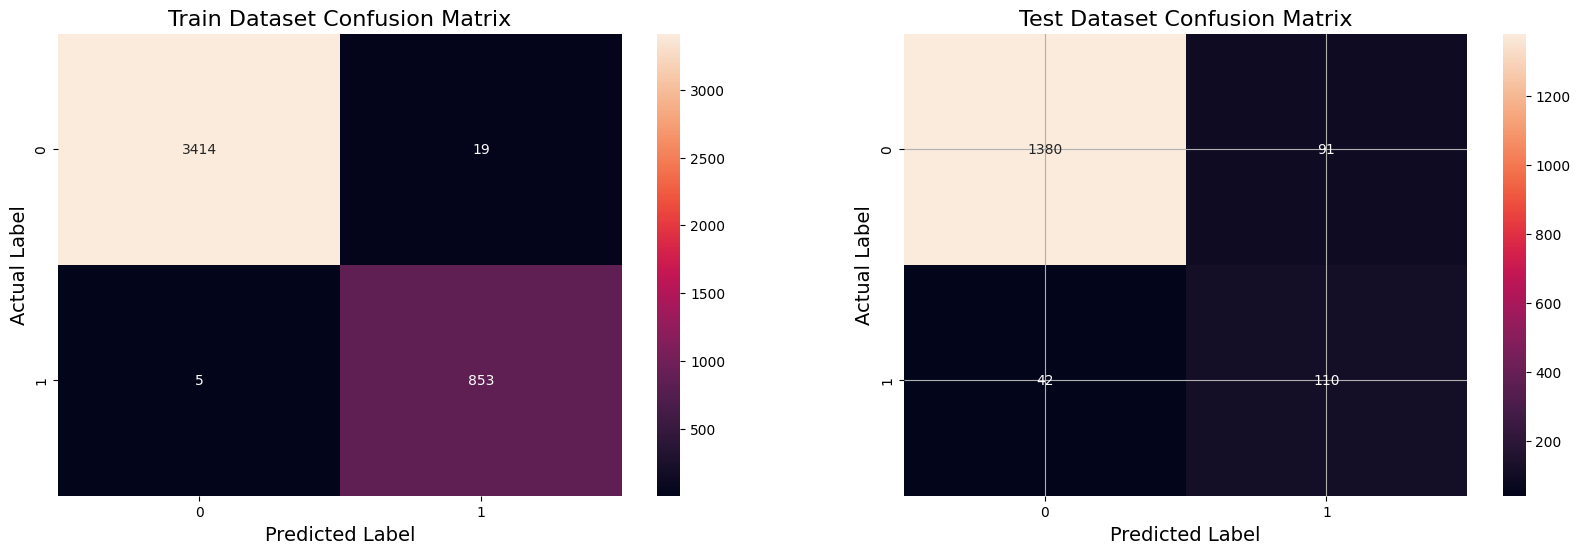

Best Threshold = 0.4142
Model AUC is : 0.9426
Model F1 Score is : 0.6232


In [91]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [92]:
table = BeautifulTable() 
table.column_headers= ["Sampling Ratio     ", "      Model       ", "    Features          ", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Reg  ", "All Features","0.9508", "0.5513"])
table.append_row(["80:20", "Logistic Reg  ", "Important Features","0.9424", "0.5600"])
table.append_row(["80:20", "Random Forest ", "All Features","0.9431", "0.6203"])
table.append_row(["80:20", "Random Forest ", "Important Features","0.9429", "0.6343"])
print(table)

+-----------------+----------------+---------------------+----------+----------+
| Sampling Ratio  |       Model    |     Features        |   AUC    | F1 Score |
|                 |                |                     |          |          |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Logistic Reg   |    All Features     |  0.951   |  0.551   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Logistic Reg   | Important Features  |  0.942   |   0.56   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Random Forest  |    All Features     |  0.943   |   0.62   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Random Forest  | Important Features  |  0.943   |  0.634   |
+-----------------+----------------+---------------------+----------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## Final Comparison:

1. Logistic Regression vs Random Forest with all the features: Using RF, F1 score increased from LR model with little decrease in AUC. Aparently it can be said the RF model performing better than LR model. But if I look at the confusion matrix, False Negative(Predicted Not-Fraud but actually it is Fraud) count is more in RF, which is very dangerous in our case. After looking at all the scores it can be said that LR is performing better than RF.

2. After filtering the important features there is no such improvement in model performence for both LR and RF. F1 score is increased even though False negative also increased. In our case decreasing False Negative is more important than decreasing False Positive. So, I can say model is performing better with all features than only using top important features.

3. After considering AUC, F1 Score, FNR it can be said the Logistic Regression model is the best model in healthcare provider fraud detection problem.